# Capstone 3 - Data Collection

### Project Background
    
    Customer satisfaction at financial institutions is key to maintaining a good reputation but data may not always be leveraged as well as it can be. I remember when I supported a call center function at a large bank, the leaders of the call center would personally read individual complaints to try and glean valuable information and take action accordingly. Using NLP to analyze the type and severity of complaints can uncover serious issues with certain business functions that are negatively impacting customer satisfaction.
    
### Data

    The data I used in this project came from the Consumer Financial Protection Bureau complaints dataset consisting of 1.8 million complaints, of which about 600k had written complaints. 
    
### Machine Learning Methods

    I plan to use Natural Language Processing to classify the product alignment of each complaint as well as the severity. This will not only give me information on what business function is driving the highest number of complaints, but will also direct me to which ones are most serious and where I must first direct my attention.

In [271]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import random
from time import time
from collections import Counter
from nltk import sent_tokenize, word_tokenize
from nltk.tokenize import RegexpTokenizer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.util import ngrams
from textblob import TextBlob
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.feature_selection import chi2
from sklearn.model_selection import train_test_split
from sklearn.utils import resample
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB, ComplementNB
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, precision_recall_curve
from gensim.corpora.dictionary import Dictionary
import gensim
import pyLDAvis.gensim
#import gensim.downloader as gensim_api
#from tensorflow.keras import models, layers, preprocessing as kprocessing
#from tensorflow.keras import backend as K
#import spacy
# download spacy english word vectors
#nlp = spacy.load('en_core_web_lg')
%matplotlib inline
plt.style.use('ggplot')

In [272]:
# testing spacy
#doc = nlp("We saw how to use different pre-built libraries for sentiment analysis using an unsupervised approach. We tried describing all the three packages in discussion i.e. IBM Watson Sentiment Analyzer, TextBlob & NLTK VADER-based sentiment analyzer. Also, we tried to explain how to use these successfully in Python.")
#print(doc.ents[1], doc.ents[1].label_)

In [273]:
# folder directory to save file
save_path = "/Users/joeboardman/Documents/Springboard/GitHub/CapstoneThree/"
fig_save_path = "/Users/joeboardman/Documents/Springboard/GitHub/CapstoneThree/figures/"
proc_data_path = "/Users/joeboardman/Documents/Springboard/GitHub/CapstoneThree/data/processed/"

In [274]:
large = 'https://files.consumerfinance.gov/ccdb/complaints.csv.zip' # 1.8m rows
banks = ['CITIBANK, N.A.', 
         'JPMORGAN CHASE & CO.', 
         'WELLS FARGO & COMPANY', 
         'BANK OF AMERICA, NATIONAL ASSOCIATION']

#read in larget dataset - 1.8m rows - 19000 from chase
df_banks = pd.read_csv(large)
# only include values from top 4 banks in list banks (exclude credit bureaus and smaller institutions)
df_banks = df_banks[df_banks.Company.isin(banks)]

In [275]:
df_banks.head()

,Date received,Product,Sub-product,Issue,Sub-issue,Consumer complaint narrative,Company public response,Company,State,ZIP code,Tags,Consumer consent provided?,Submitted via,Date sent to company,Company response to consumer,Timely response?,Consumer disputed?,Complaint ID
27,2020-10-01,Checking or savings account,Checking account,Managing an account,Problem accessing account,NaN,NaN,JPMORGAN CHASE & CO.,NY,12549,NaN,NaN,Referral,2020-10-02,Closed with explanation,Yes,NaN,3879354
54,2020-10-08,Checking or savings account,Checking account,Managing an account,Problem using a debit or ATM card,NaN,Company has responded to the consumer and the ...,WELLS FARGO & COMPANY,TX,77071,NaN,NaN,Phone,2020-10-08,Closed with explanation,Yes,NaN,3888551
55,2019-05-07,Checking or savings account,Checking account,Opening an account,Account opened as a result of fraud,NaN,Company has responded to the consumer and the ...,"BANK OF AMERICA, NATIONAL ASSOCIATION",CA,95355,Servicemember,NaN,Phone,2019-05-07,Closed with explanation,Yes,NaN,3235168
56,2019-05-09,Checking or savings account,Checking account,Managing an account,Deposits and withdrawals,NaN,NaN,JPMORGAN CHASE & CO.,NJ,07054,Older American,NaN,Phone,2019-05-09,Closed with monetary relief,Yes,NaN,3236981
88,2019-02-16,"Credit reporting, credit repair services, or o...",Credit reporting,Incorrect information on your report,Information belongs to someone else,On XX/XX/XXXX I received a letter from the IRS...,Company has responded to the consumer and the ...,WELLS FARGO & COMPANY,CA,956XX,NaN,Consent provided,Web,2019-02-16,Closed with non-monetary relief,Yes,NaN,3154014


In [276]:
# drop rows without a written complaint
df_banks = df_banks.dropna(subset=['Consumer complaint narrative']).reset_index(drop=True)
df_banks.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 77067 entries, 0 to 77066
Data columns (total 18 columns):
 #   Column                        Non-Null Count  Dtype 
---  ------                        --------------  ----- 
 0   Date received                 77067 non-null  object
 1   Product                       77067 non-null  object
 2   Sub-product                   68783 non-null  object
 3   Issue                         77067 non-null  object
 4   Sub-issue                     41739 non-null  object
 5   Consumer complaint narrative  77067 non-null  object
 6   Company public response       56642 non-null  object
 7   Company                       77067 non-null  object
 8   State                         76494 non-null  object
 9   ZIP code                      59863 non-null  object
 10  Tags                          14456 non-null  object
 11  Consumer consent provided?    77067 non-null  object
 12  Submitted via                 77067 non-null  object
 13  Date sent to com

In [277]:
# drop needless columns
df_banks.drop(['Date received', 'Sub-product', 'Sub-issue', 'ZIP code', 'Tags', 'Consumer consent provided?',
        'Submitted via', 'Date sent to company', 'Timely response?', "Company public response", 'State'], 
        axis=1, inplace=True)

In [278]:
# rename columns to remove spaces
df_banks = df_banks.rename(columns={"Consumer complaint narrative": "complaint_text", 
                                    "Company response to consumer":"company_response",
                                    "Consumer disputed?":"disputed",
                                    "Complaint ID":"complaint_ID"})


In [279]:


# convert 'disputed' column to int instead of 'yes'/'no'
df_banks['disputed'] = [1 if b=='Yes' else 0 for b in df_banks.disputed]

df_banks.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 77067 entries, 0 to 77066
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Product           77067 non-null  object
 1   Issue             77067 non-null  object
 2   complaint_text    77067 non-null  object
 3   Company           77067 non-null  object
 4   company_response  77067 non-null  object
 5   disputed          77067 non-null  int64 
 6   complaint_ID      77067 non-null  int64 
dtypes: int64(2), object(5)
memory usage: 4.1+ MB


In [281]:
# different products - notice duplication (i.e. 'payday loan' and 'payday loan, title loan, or personal loan')
df_banks['Product'].value_counts()

Credit card or prepaid card                                                     16129
Mortgage                                                                        15787
Checking or savings account                                                     12535
Credit card                                                                      8126
Bank account or service                                                          7305
Credit reporting, credit repair services, or other personal consumer reports     6774
Debt collection                                                                  4542
Money transfer, virtual currency, or money service                               2156
Vehicle loan or lease                                                             983
Consumer Loan                                                                     982
Student loan                                                                      849
Payday loan, title loan, or personal loan             

In [282]:
# consolidate duplicative products
df_banks.loc[df_banks.Product == 'Mortgage', ['Product']] = 'Consumer Loan'
df_banks.loc[df_banks.Product == 'Student Loan', ['Product']] = 'Consumer Loan'
df_banks.loc[df_banks.Product == 'Payday loan, title loan, or personal loan', ['Product']] = 'Consumer Loan'
df_banks.loc[df_banks.Product == 'Payday loan', ['Product']] = 'Consumer Loan'
df_banks.loc[df_banks.Product == 'Vehicle loan or lease', ['Product']] = 'Consumer Loan'
df_banks.loc[df_banks.Product == 'Student loan', ['Product']] = 'Consumer Loan'
df_banks.loc[df_banks.Product == 'Prepaid card', ['Product']] = 'Credit card or prepaid card'
df_banks.loc[df_banks.Product == 'Money transfers', ['Product']] = 'Other financial service'
df_banks.loc[df_banks.Product == 'Credit reporting, credit repair services, or other personal consumer reports', ['Product']] = 'Credit reporting'
df_banks.loc[df_banks.Product == 'Credit card', ['Product']] = 'Credit card or prepaid card'
df_banks.loc[df_banks.Product == 'Checking or savings account', ['Product']] = 'Bank account or service'
df_banks.loc[df_banks.Product == 'Virtual currency', ['Product']] = 'Other financial service'
df_banks.loc[df_banks.Product == 'Money transfer, virtual currency, or money service', ['Product']] = 'Other financial service'

df_banks.Product.value_counts()

Credit card or prepaid card    24371
Bank account or service        19840
Consumer Loan                  18984
Credit reporting                6918
Debt collection                 4542
Other financial service         2412
Name: Product, dtype: int64

In [283]:
# check for duplicates
duplicateRowsDF = df_banks[df_banks.duplicated()]
print('Duplicate rows: ', len(duplicateRowsDF))
# drop duplicates
df_banks.drop_duplicates(keep='first', inplace=True)
duplicateRowsDF = df_banks[df_banks.duplicated()]
print('Duplicate rows: ', len(duplicateRowsDF))

Duplicate rows:  0
Duplicate rows:  0


In [284]:
# Feature Engineering - Create column for # of sentences in complaint

sent_tokens = [sent_tokenize(item) for item in df_banks.complaint_text]
len_sent_tokens = []

for i in range(len(sent_tokens)):
    len_sent_tokens.append(len(sent_tokens[i]))

df_banks['sentences'] = len_sent_tokens


In [285]:
# Feature Engineering - Create column for # of words in complaint

word_tokens = [word_tokenize(item) for item in df_banks.complaint_text]
len_word_tokens = []

for i in range(len(word_tokens)):
    len_word_tokens.append(len(word_tokens[i]))

df_banks['words'] = len_word_tokens


In [286]:
# Feature Engineering - Create column for # of ? and ! in complaint

df_banks['special_chars'] = df_banks.complaint_text.str.count('\!') + df_banks.complaint_text.str.count('\?')
df_banks.head()


<>:3: DeprecationWarning: invalid escape sequence \!
<>:3: DeprecationWarning: invalid escape sequence \?
<>:3: DeprecationWarning: invalid escape sequence \!
<>:3: DeprecationWarning: invalid escape sequence \?
<>:3: DeprecationWarning: invalid escape sequence \!
<>:3: DeprecationWarning: invalid escape sequence \?
<ipython-input-286-536a0b3bddf8>:3: DeprecationWarning: invalid escape sequence \!
  df_banks['special_chars'] = df_banks.complaint_text.str.count('\!') + df_banks.complaint_text.str.count('\?')
<ipython-input-286-536a0b3bddf8>:3: DeprecationWarning: invalid escape sequence \?
  df_banks['special_chars'] = df_banks.complaint_text.str.count('\!') + df_banks.complaint_text.str.count('\?')


,Product,Issue,complaint_text,Company,company_response,disputed,complaint_ID,sentences,words,special_chars
0,Credit reporting,Incorrect information on your report,On XX/XX/XXXX I received a letter from the IRS...,WELLS FARGO & COMPANY,Closed with non-monetary relief,0,3154014,22,412,1
1,Consumer Loan,Struggling to pay mortgage,I am filing this complaint after receiving a l...,JPMORGAN CHASE & CO.,Closed with explanation,0,3169014,18,468,1
2,Credit card or prepaid card,Problem with a purchase shown on your statement,"On XX/XX/XXXX, Bank of America mailed out a ca...","BANK OF AMERICA, NATIONAL ASSOCIATION",Closed with monetary relief,0,3121663,7,171,0
3,Bank account or service,Problem with a lender or other company chargin...,I made an appointment at XXXX for myself and a...,"BANK OF AMERICA, NATIONAL ASSOCIATION",Closed with explanation,0,3128523,7,91,0
4,Credit card or prepaid card,Closing your account,I was using my chase credit card like a regula...,JPMORGAN CHASE & CO.,Closed with explanation,0,3288810,1,47,0


In [287]:
round(df_banks.describe().T,3)

,count,mean,std,min,25%,50%,75%,max
disputed,77067.0,0.085,0.279,0.0,0.0,0.0,0.0,1.0
complaint_ID,77067.0,2705508.861,718700.118,1290200.0,2123084.5,2790824.0,3293214.0,3973996.0
sentences,77067.0,11.913,11.810,1.0,5.0,9.0,15.0,290.0
words,77067.0,273.784,277.504,2.0,108.0,198.0,348.0,5965.0
special_chars,77067.0,0.670,2.569,0.0,0.0,0.0,0.0,194.0


In [288]:
# words to remove from stop words
stop_remove = ['no', 'not', "don't"]
stop_add = ['xx', 'xxxx', '00']

def add_or_remove_stop_words(remove_list, add_list):
    '''adding or removing multiple stop words instead of repetitive code'''
    
    global STOP_WORDS
    STOP_WORDS = stopwords.words('english')
    for i in range(len(remove_list)):
        STOP_WORDS.remove(remove_list[i])
    
    for i in range(len(add_list)):
        STOP_WORDS.append(add_list[i])
    
# remove negation stop words
add_or_remove_stop_words(stop_remove, stop_add)


In [289]:
# text preprocessing formulas
def preprocess_text(text):
    '''tokenize, lemmatize and remove stop words from text'''
    
    # Tokenise words while ignoring punctuation
    tokeniser = RegexpTokenizer(r'\w+')
    tokens = tokeniser.tokenize(text)
    bigram = list(ngrams(tokens, 2)) 
    
    # Lowercase and lemmatise 
    lemmatiser = WordNetLemmatizer()
    lemmas = [lemmatiser.lemmatize(token.lower(), pos='v') for token in tokens]
    
    # Remove stopwords
    keywords= [lemma for lemma in lemmas if lemma not in STOP_WORDS]
    
    #convert text back to string
    text_str = " ".join(keywords)
    return text_str

In [290]:
# Get the polarity score of each complaint
def get_TextBlob_polarity(text):
    '''Assign polarity score between -1 to 1 for text'''
    
    polarity = TextBlob(text).sentiment.polarity
    return polarity

def get_TextBlob_subjectivity(text):
    '''Assign polarity score between -1 to 1 for text'''
    
    subjectivity = TextBlob(text).sentiment.subjectivity
    return subjectivity

In [291]:
# Preprocess complaint_text column then run the textblob polarity 
df_banks['preprocessed_complaint'] = df_banks.complaint_text.apply(preprocess_text)

df_banks['polarity'] = [get_TextBlob_polarity(str(complaint)) for complaint in df_banks.preprocessed_complaint]
df_banks['subjectivity'] = [get_TextBlob_subjectivity(str(complaint)) for complaint in df_banks.preprocessed_complaint]


In [309]:
print(df_banks.subjectivity.nsmallest())
print(df_banks.subjectivity.nlargest())

25     0.0
45     0.0
116    0.0
131    0.0
142    0.0
Name: subjectivity, dtype: float64
34      1.0
127     1.0
168     1.0
1169    1.0
1727    1.0
Name: subjectivity, dtype: float64


In [292]:
df_banks.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 77067 entries, 0 to 77066
Data columns (total 13 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Product                 77067 non-null  object 
 1   Issue                   77067 non-null  object 
 2   complaint_text          77067 non-null  object 
 3   Company                 77067 non-null  object 
 4   company_response        77067 non-null  object 
 5   disputed                77067 non-null  int64  
 6   complaint_ID            77067 non-null  int64  
 7   sentences               77067 non-null  int64  
 8   words                   77067 non-null  int64  
 9   special_chars           77067 non-null  int64  
 10  preprocessed_complaint  77067 non-null  object 
 11  polarity                77067 non-null  float64
 12  subjectivity            77067 non-null  float64
dtypes: float64(2), int64(5), object(6)
memory usage: 8.2+ MB


In [293]:
print(df_banks.polarity.nsmallest())
print(df_banks.polarity.nlargest())

5010    -1.0
13199   -1.0
33416   -1.0
34542   -1.0
45690   -1.0
Name: polarity, dtype: float64
2556    1.0
3753    1.0
4011    1.0
5898    1.0
7514    1.0
Name: polarity, dtype: float64


In [294]:
print('Most positive review: ', df_banks.iloc[df_banks.polarity.idxmax(),10])
print()
print('Most Negative Review: ', df_banks.iloc[df_banks.polarity.idxmin(),10])

Most positive review:  come attention theres incorrect information account not mine never mine ive never cosign allow information use heres account 1 cbna 190 xxxx2 0 3 0 xxxx4 best buy cbna 240 5 macys dsnb 500 07 2017 6 verizon 1000 06 2017 7 amsher 160 8 1000

Most Negative Review:  citi bank horrible electronic systems upload document verification apply 2019 accelerate save account get email upload wifes drivers license upload docs via docusign system receive confirmation noon get another email yet another email 7 email ask upload docs despite upload docs 3 time still 2 weeks get letter date account number no debit card try reach via chat agent mention citi dispatch week ago 3 weeks still no debit card call agent mention wait license copy issue account number case agent lie us dispatch debit card well 3 weeks hassle stil dont debit card want close account citi tell write use info delete since no longer go customer


In [295]:
df_banks.head()

,Product,Issue,complaint_text,Company,company_response,disputed,complaint_ID,sentences,words,special_chars,preprocessed_complaint,polarity,subjectivity
0,Credit reporting,Incorrect information on your report,On XX/XX/XXXX I received a letter from the IRS...,WELLS FARGO & COMPANY,Closed with non-monetary relief,0,3154014,22,412,1,receive letter irs state identity may compromi...,0.069345,0.300595
1,Consumer Loan,Struggling to pay mortgage,I am filing this complaint after receiving a l...,JPMORGAN CHASE & CO.,Closed with explanation,0,3169014,18,468,1,file complaint receive letter chase today alle...,-0.175926,0.208333
2,Credit card or prepaid card,Problem with a purchase shown on your statement,"On XX/XX/XXXX, Bank of America mailed out a ca...","BANK OF AMERICA, NATIONAL ASSOCIATION",Closed with monetary relief,0,3121663,7,171,0,bank america mail card new authorize user cred...,0.081061,0.388578
3,Bank account or service,Problem with a lender or other company chargin...,I made an appointment at XXXX for myself and a...,"BANK OF AMERICA, NATIONAL ASSOCIATION",Closed with explanation,0,3128523,7,91,0,make appointment another person contract direc...,0.000000,0.316667
4,Credit card or prepaid card,Closing your account,I was using my chase credit card like a regula...,JPMORGAN CHASE & CO.,Closed with explanation,0,3288810,1,47,0,use chase credit card like regular credit card...,0.000000,0.076923


In [296]:
# create formula to apply sentiment intensity analyzer
analyser = SentimentIntensityAnalyzer()

def sentiment_analyzer_scores(text):
    score = analyser.polarity_scores(text)
    return score['compound']

In [298]:
# vader sentiment analysis to assess positive/negative as well as how negative a review is
df_banks['sentiment_vader'] = [sentiment_analyzer_scores(str(complaint)) for complaint in \
                               df_banks.preprocessed_complaint]

In [300]:
print(df_banks.sentiment_vader.nsmallest())
print(df_banks.sentiment_vader.nlargest())

34293   -0.9999
34420   -0.9996
6830    -0.9995
36148   -0.9994
4092    -0.9993
Name: sentiment_vader, dtype: float64
4877     0.9999
7149     0.9999
29327    0.9999
31585    0.9998
67492    0.9998
Name: sentiment_vader, dtype: float64


In [302]:
#print('Most positive review: ', df_banks.iloc[df_banks.sentiment_vader.idxmax(),2])
#print()
#print('Most Negative Review: ', df_banks.iloc[df_banks.sentiment_vader.idxmin(),2])
#print('Most Negative Review: ', df_banks.iloc[4091,2])
print('Most Positive Review: ', df_banks.iloc[31441,2])

Most Positive Review:  i tried disputing the accuracy of the account multiple times with the credit bureaus and directly to you guys and nothing is happening every time i send a dispute i get the run around to go back to the bureaus and after i send them a dispute they tell me to go back to you finally i sent a dispute on XX/XX/18 to XXXX and XXXX  with supporting documentation showing that you guys are reporting differently to from XXXX to XXXX  and i find that odd because i have already submitted multiple disputes with you guys and the bureaus and you both said that all information on the report is 100 % accurate furthermore i see that XXXX   deleted this account how did they delete it if you verified it with XXXX   and XXXX


In [304]:
# Save DataFrame as csv to be used for EDA and Modeling
save = os.path.join(save_path, 'data/processed', 'DW_complaints.csv')
df_banks.to_csv(save)


# Steps - 11/18/20:

1. Create Tf-Idf vectorizer
    1. dimensionality reduction
        2. 
2. Create classifier for Product
3. Pipeline with vectorizer and classifier?
3. Feature Engineering prior to prediction of severity sentiment
4. Sentiment analysis to predict sentiment
    1. TextBlob for polarity
        1. Preprocess the complaint before TextBlob?
    2. word2vec for word similarities
    3. 

### Thoughts:
- dimensionality reduction
    - find optimal number of features
    - chi squared test to find out dependence b/w feature and target
        - only keep values with certain p-value indicating statistical significance and dependence b/w feature and target
- train and run classifiers for product alignment of complaint - naive bayes?
- figure out how to predict severity
    - TextBlob or IBM Watson sentiment analysis to get polarity of complaint
    - could use VADER for valence?
        - was developed for tweets - could be applicable to written complaints
    - creating other features using text column
        - number of punctuation marks (indicator of emotionally charged statement)
        - number of words, sentences in each complaint
    - consumer disputed column?
        - discontinued 4/23/17 - latest date in data is 9/9/17
        - could be indicator or the severity of complaint
- recommend next action based on product alignment and severity

### Ideas:
- highly sensitive products?
- within each class - most common words - highest tfidf weight
- pipeline
    - gridsearch on pipeline?
- spaCy
    - word2vec NN
- evaluation methods
    - confusion matrix
    - ROC curve
    - classification report
    
### Value Calc:
- Exec and team all making 150k-250k reviewing complaints is expensive
- model that categorizes, analyzes severity could highlight areas in the business that have issues and allow team to focus there instead of spending time reading reviews and gaining insight manually



# Capstone 3 - EDA

## Exploratory Data Analysis on complaints dataset

### Ideas:
- word count
- sentence count
- top words
- top tfidf words
- avg sentiment per product
- words/complaint per product
- top bigrams/trigrams
- 

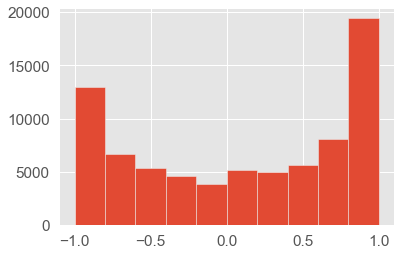

In [235]:
df_banks.sentiment_vader.hist()

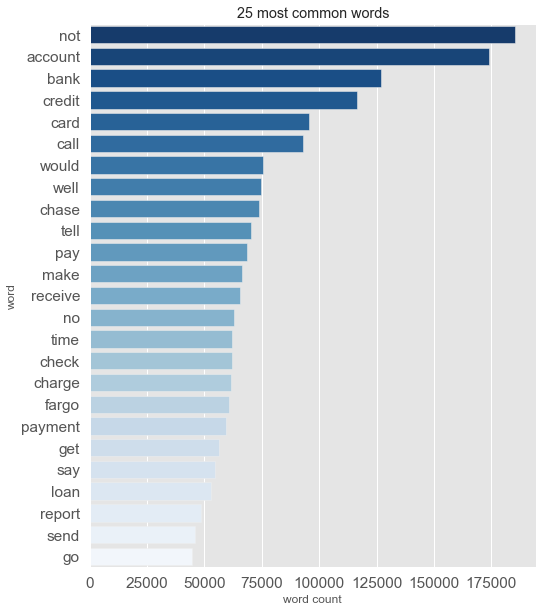

In [219]:
# count top words
most = Counter(" ".join(df_banks["preprocessed_complaint"]).split()).most_common(25)
df_most = pd.DataFrame(most, columns=['word', 'count'])
plt.figure(figsize=(8,10))
sns.barplot(x='count',y='word', data=df_most, palette='Blues_r')
plt.xlabel('word count')
plt.ylabel('word')
plt.title('25 most common words')
plt.show()

In [247]:
# formula to get top 20 ngrams
def get_top_ngram(corpus, n=None):
    vec = CountVectorizer(ngram_range=(n, n)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) 
                  for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:20]

In [248]:
# get top bigrams
top_n_bigrams = get_top_ngram(df_banks['preprocessed_complaint'], 2)


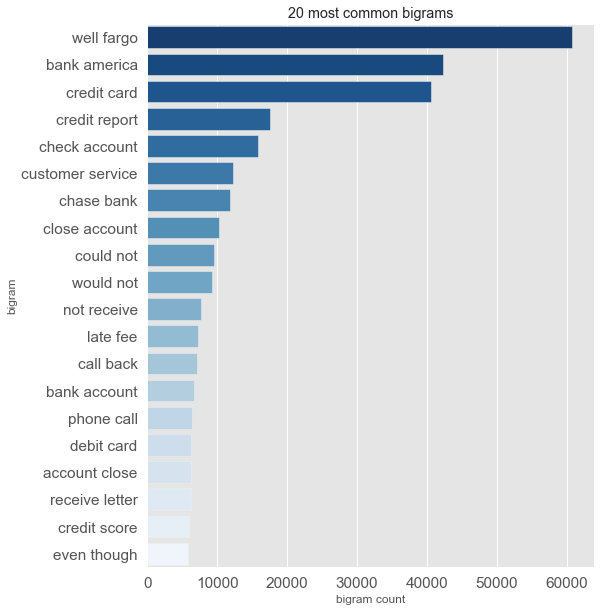

In [249]:
# plot top 20 bigrams
x_bi, y_bi = map(list, zip(*top_n_bigrams))
plt.figure(figsize=(8,10))
sns.barplot(x=y_bi, y=x_bi, palette='Blues_r')
plt.xlabel('bigram count')
plt.ylabel('bigram')
plt.title('20 most common bigrams')
plt.show()

In [250]:
# get top trigrams
top_n_trigrams=get_top_ngram(df_banks['preprocessed_complaint'], 3)


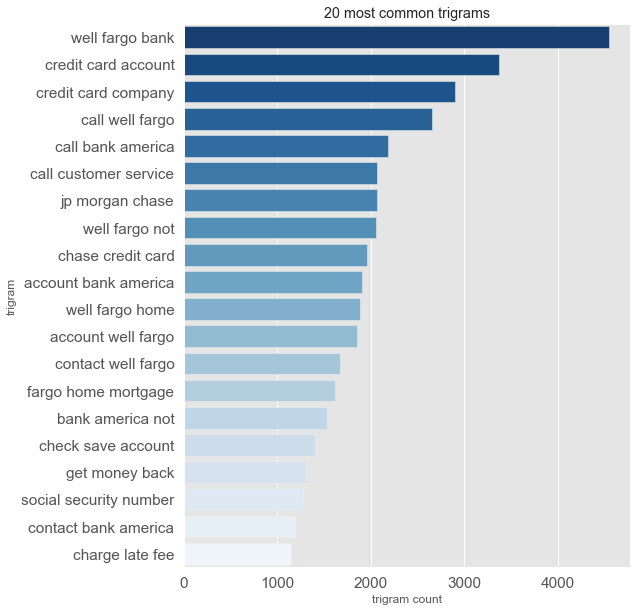

In [251]:
# plot top 20 trigrams
x_tri, y_tri = map(list,zip(*top_n_trigrams))
plt.figure(figsize=(8,10))
sns.barplot(x=y_tri, y=x_tri, palette='Blues_r')
plt.xlabel('trigram count')
plt.ylabel('trigram')
plt.title('20 most common trigrams')
plt.show()

In [241]:
def get_lda_objects(text):
    '''create instance of Latent Dirichlet Allocation (LDA) model as well as bag-of-words and gensim dictionary to be used to train model'''
    stop = STOP_WORDS
    
    def _preprocess_text(text):
        '''preprocess test to create corpus'''
        corpus = []
        lem = WordNetLemmatizer()
        for news in text:
            words = [w for w in word_tokenize(news) if (w not in stop)]

            words = [lem.lemmatize(w) for w in words if len(w)>2]

            corpus.append(words)
        return corpus
    
    corpus = _preprocess_text(text)
    
    dic = gensim.corpora.Dictionary(corpus)
    bow_corpus = [dic.doc2bow(doc) for doc in corpus]
    
    lda_model =  gensim.models.LdaMulticore(bow_corpus, 
                                   num_topics = 6, 
                                   id2word = dic,                                    
                                   passes = 10)
                                   #workers = 2)
    
    return lda_model, bow_corpus, dic

def plot_lda_vis(lda_model, bow_corpus, dic):
    '''plot pyLDAvis visual for interactive view of topic clusters and relevant words'''
    pyLDAvis.enable_notebook()
    vis = pyLDAvis.gensim.prepare(lda_model, bow_corpus, dic)
    return vis

In [242]:
# get LDA objects to run 
t0 = time()
lda_model, bow_corpus, dic = get_lda_objects(df_banks.preprocessed_complaint)
print('Runtime:', round((time() - t0) / 60,1), 'minutes')

In [243]:
lda_model.show_topics()

[(0,
  '0.035*"well" + 0.034*"fargo" + 0.032*"loan" + 0.023*"mortgage" + 0.020*"payment" + 0.019*"not" + 0.015*"home" + 0.013*"pay" + 0.010*"modification" + 0.010*"year"'),
 (1,
  '0.070*"account" + 0.064*"bank" + 0.042*"check" + 0.023*"america" + 0.020*"money" + 0.019*"not" + 0.017*"deposit" + 0.016*"fund" + 0.012*"chase" + 0.012*"fee"'),
 (2,
  '0.059*"card" + 0.032*"chase" + 0.032*"charge" + 0.028*"credit" + 0.025*"not" + 0.016*"dispute" + 0.013*"purchase" + 0.011*"use" + 0.009*"receive" + 0.009*"transaction"'),
 (3,
  '0.043*"credit" + 0.037*"payment" + 0.036*"account" + 0.022*"pay" + 0.021*"not" + 0.020*"card" + 0.017*"balance" + 0.014*"late" + 0.014*"fee" + 0.013*"citibank"'),
 (4,
  '0.020*"report" + 0.017*"bank" + 0.017*"not" + 0.014*"credit" + 0.013*"information" + 0.011*"debt" + 0.010*"letter" + 0.010*"request" + 0.010*"account" + 0.010*"file"'),
 (5,
  '0.038*"call" + 0.025*"not" + 0.024*"tell" + 0.020*"say" + 0.019*"get" + 0.016*"would" + 0.013*"ask" + 0.012*"back" + 0.012*

In [260]:
# choose random complaint to assign topic
df_banks.complaint_text[4311]

'CHASE BANK refused to refund a disputed charge I have from XXXX ( Booked through XXXX ) {$2300.00} on XX/XX/XXXX. That charge made by Travel Agency and the agency has cancelled the transaction according to numerous emails. I canceled booking on XX/XX/XXXX. Then I got letter from travel agency that my bookings are canceled and provide all information about cancelation policy including full refund, the handling time should be around 8 weeks. Its almost 6 months, since I canceled bookings and I still didnt get refund. On XX/XX/XXXX I have sent them email where I asked about refund issue and why I didnt get refund. They answer me we have checked and found that there is chargeback by your bank. Hence we request you to please speak with your bank regarding refund. After that tried to dispute this charge with chase, every time when I called to chase customer service I had different instructions from them about what information I need to provide in fax, they never contacted me in order to get

In [261]:
# topic alignment for specific complaint above
for index, score in sorted(lda_model[bow_corpus[4311]], key=lambda tup: -1*tup[1]):
    print("\nScore: {}\t \nTopic: {}".format(score, lda_model.print_topic(index, 10)))


Score: 0.5892564058303833	 
Topic: 0.059*"card" + 0.032*"chase" + 0.032*"charge" + 0.028*"credit" + 0.025*"not" + 0.016*"dispute" + 0.013*"purchase" + 0.011*"use" + 0.009*"receive" + 0.009*"transaction"

Score: 0.29506802558898926	 
Topic: 0.038*"call" + 0.025*"not" + 0.024*"tell" + 0.020*"say" + 0.019*"get" + 0.016*"would" + 0.013*"ask" + 0.012*"back" + 0.012*"send" + 0.011*"phone"

Score: 0.0866498351097107	 
Topic: 0.020*"report" + 0.017*"bank" + 0.017*"not" + 0.014*"credit" + 0.013*"information" + 0.011*"debt" + 0.010*"letter" + 0.010*"request" + 0.010*"account" + 0.010*"file"

Score: 0.025827188044786453	 
Topic: 0.070*"account" + 0.064*"bank" + 0.042*"check" + 0.023*"america" + 0.020*"money" + 0.019*"not" + 0.017*"deposit" + 0.016*"fund" + 0.012*"chase" + 0.012*"fee"


In [244]:
# visual of LDA and different topics
plot_lda_vis(lda_model, bow_corpus, dic)

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
5      0.056217 -0.002212       1        1  23.035059
0      0.002709 -0.184958       2        1  18.763582
3      0.085431 -0.017020       3        1  17.688257
1      0.081273  0.106683       4        1  14.845708
4     -0.230735  0.030057       5        1  13.524431
2      0.005104  0.067450       6        1  12.142961, topic_info=         Term           Freq          Total Category  logprob  loglift
1     account  173662.000000  173662.000000  Default  30.0000  30.0000
10       card   95944.000000   95944.000000  Default  29.0000  29.0000
7        bank  127512.000000  127512.000000  Default  28.0000  28.0000
20     credit  114344.000000  114344.000000  Default  27.0000  27.0000
262     check   62486.000000   62486.000000  Default  26.0000  26.0000
..        ...            ...            ...      ...      ...      ...
75     return    4400.210449   15671.173828   Topic6  -5.4801   0.8382
86       time    5454.556152   62177.941406   Topic6  -5.2653  -0.3251
800    amount    4837.627930   31799.343750   Topic6  -5.3853   0.2254
272  customer    4599.917969   30239.167969   Topic6  -5.4357   0.2253
239       pay    4708.007324   69348.359375   Topic6  -5.4125  -0.5815

[519 rows x 6 columns], token_table=       Topic      Freq  Term
term                        
7376       5  0.998148  1692
428        1  0.103652  2018
428        2  0.009638  2018
428        3  0.174901  2018
428        4  0.284583  2018
...      ...       ...   ...
183        5  0.051079  year
183        6  0.034295  year
5396       1  0.996398  yell
15303      4  0.994792   yen
16533      4  0.990887   zed

[1297 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[6, 1, 4, 2, 5, 3])

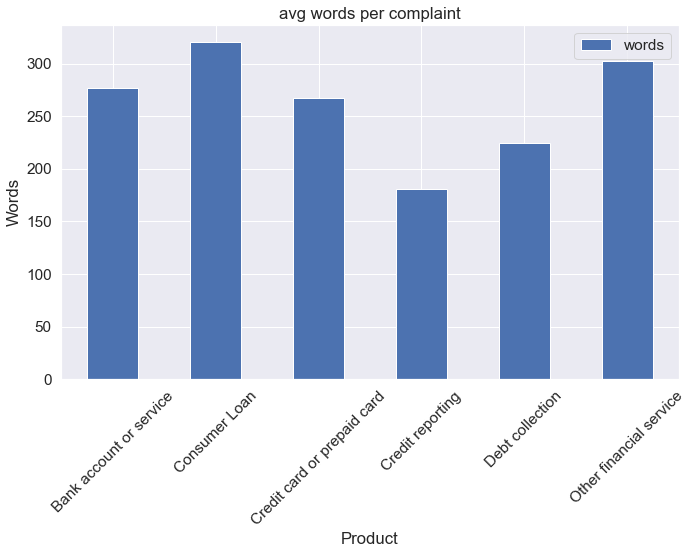

In [190]:
# show average words per complaint by product
df_banks_w = df_banks.groupby(['Product'])[['words']].mean().round(2)
df_banks_w.plot(kind='bar', figsize=(10,8), title='avg words per complaint', rot=45)
plt.xlabel('Product')
plt.ylabel('Words')
plt.tight_layout()
plt.show()

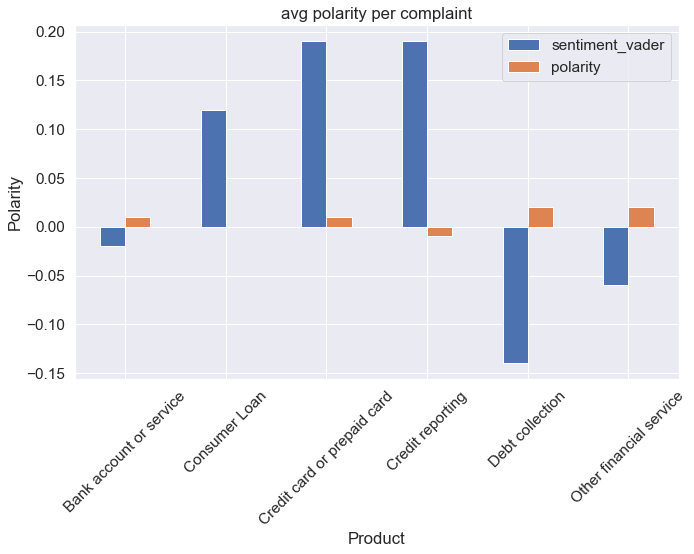

In [191]:
# average polarity by product
df_banks_s = df_banks.groupby(['Product'])[['sentiment_vader', 'polarity']].mean().round(2)
df_banks_s.plot(kind='bar', figsize=(10,8), title='avg polarity per complaint', rot=45)
plt.xlabel('Product')
plt.ylabel('Polarity')
plt.tight_layout()
plt.show()

In [192]:
df_banks_s

,sentiment_vader,polarity
Product,,
Bank account or service,-0.02,0.01
Consumer Loan,0.12,0.00
Credit card or prepaid card,0.19,0.01
Credit reporting,0.19,-0.01
Debt collection,-0.14,0.02
Other financial service,-0.06,0.02


In [254]:
# read in ground truth of severity df that was created
os.chdir(proc_data_path)
df_sev = pd.read_csv('complaints_ground_truth.csv', index_col=0)
df_sev.head()

,complaint_text,complaint_ID,severe,preprocessed_complaint,polarity
70509,on XX/XX/2018 i applied for a credit through w...,2975717,0,2018 apply credit well fargo online site inten...,0.029282
14855,I had previously submitted the following compl...,3493387,0,previously submit follow complaint regard bank...,-0.030556
17961,I have a wells fargo account. XXXX XXXX kept ...,3583070,1,well fargo account keep chagring bank account ...,-0.200000
18625,The Home Depot/Citibank North America says tha...,3775391,0,home depot citibank north america say late dat...,0.066667
50357,"Hello, my name is XXXX XXXX and I am contactin...",1787885,1,hello name contact find government agency may ...,0.053444


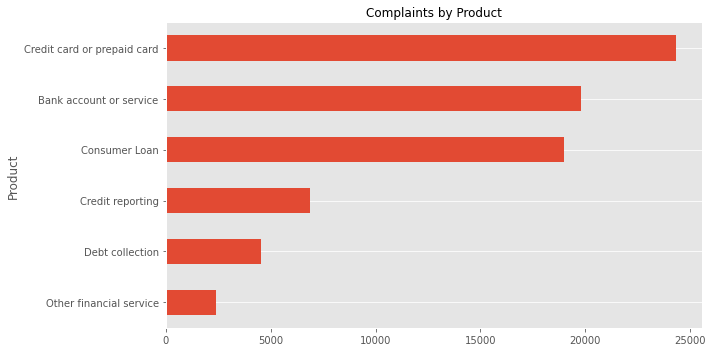

In [104]:
# number of complaints for each product
fig, ax = plt.subplots(figsize=(10,5))
plt.title("Complaints by Product", fontsize=12)
df_banks["Product"].reset_index().groupby("Product").count().sort_values(by="index").plot(kind="barh", legend=False, ax=ax).grid(axis='x')
plt.tight_layout()
plt.show()

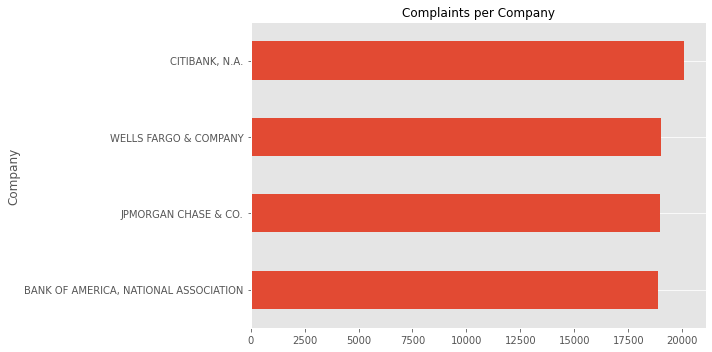

In [102]:
# number of complaints by bank
fig, ax = plt.subplots(figsize=(10,5))
plt.title("Complaints per Company", fontsize=12)
df_banks["Company"].reset_index().groupby("Company").count().sort_values(by="index").plot(kind="barh", legend=False, ax=ax).grid(axis='x')
plt.tight_layout()
plt.show()

# Discoveries from EDA

- Latent Dirichlet Allocation (LDA)
    - LDA allows sets of observations to be explained by unobserved groups that explain why some parts of the data are similar
    - top 10 words present in topic are chosen to represent the topic
    - Using LDA model, I created clusters in the complaints
    - Within the clusters, I found the most common topic was more related to customer service than any product category
- Using top bigrams and trigrams, Wells Fargo seems to be mentioned far more than any company. Could demonstrate that customer believes wells fargo is at fault more than other banks receiving complaints
- Polarity/VADER sentiment not correlated with simpler metrics like words/complaint
- Cannot really rely on polarity and VADER sentiment analysis - conflict too much




